In [21]:
# Importing the libraries

import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append("..")
warnings.filterwarnings('ignore')
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import RandomForestRegressor

In [2]:
# Importing some scripts

from scripts.data_vizualization import Data_Viz 
from scripts.data_cleaning import DataCleaner
from scripts.data_transformation import DataTransformer

DC = DataCleaner()
DV = Data_Viz()
DT = DataTransformer()

In [3]:
# Importing the train data and check for outliers

train = pd.read_csv('../data/train_data_clean.csv',index_col='Date')
DV.summ_columns(train)

,variables,missing_count,missing_percent_(%),data_type,unique_values
0,Store,0,0.0,int64,1115
1,DayOfWeek,0,0.0,int64,7
2,Sales,0,0.0,float64,13194
3,Customers,0,0.0,float64,1423
4,Open,0,0.0,int64,2
5,Promo,0,0.0,int64,2
6,StateHoliday,0,0.0,object,4
7,SchoolHoliday,0,0.0,int64,2
8,StoreType,0,0.0,object,4
9,Assortment,0,0.0,object,3


In [4]:
# Creating a new column

train.loc[train['DayOfMonth'] >= 20,'DayStatus'] = 'End of Month' 
train.loc[(train['DayOfMonth'] < 20) & (train['DayOfMonth'] > 10),'DayStatus'] = 'Mid of Month' 
train.loc[train['DayOfMonth'] < 10,'DayStatus'] = 'Begining of Month' 

In [5]:
# Finding out if the column worked as planned

train['DayStatus'].value_counts()

End of Month         380995
Mid of Month         301365
Begining of Month    301364
Name: DayStatus, dtype: int64

In [6]:
# Creating a new column for store having competator or not

train.loc[train['CompetitionOpenSinceMonth'] != 'Not Available','HasCompetator'] = 1 
train.loc[train['CompetitionOpenSinceMonth'] == 'Not Available','HasCompetator'] = 0

In [7]:
# Lets see the catagorical and numerical columns and list out all the numerical columns

categorical_col, numerical_col = DT.sep_cat_num(train)
numerical_col.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,Promo2,Year,Month,DayOfMonth,Weekday,HasCompetator
Date,,,,,,,,,,,,,,
2015-07-31,1,5,5263.0,555.0,1,1,1,1270.0,0,2015,7,31,1,1.0
2015-07-31,2,5,6064.0,625.0,1,1,1,570.0,1,2015,7,31,1,1.0
2015-07-31,3,5,8314.0,821.0,1,1,1,14130.0,1,2015,7,31,1,1.0
2015-07-31,4,5,13995.0,596.0,1,1,1,620.0,0,2015,7,31,1,1.0
2015-07-31,5,5,4822.0,559.0,1,1,1,29910.0,0,2015,7,31,1,1.0


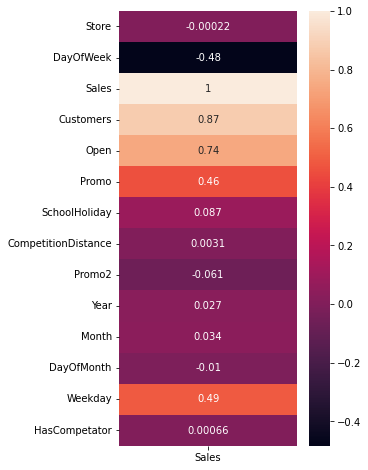

<Figure size 432x288 with 0 Axes>

In [8]:
# Lets check the most correlated columns and see the heatmap

plt.figure(figsize=(4, 8))
sns.heatmap(numerical_col.corr().loc['Sales',:].to_frame(), annot=True)
plt.show()
plt.savefig('../charts/sales_vs_all_corr.jpg')

#### From the above correlation graph we can see that Weekday, Promo, Open, Customer and DaysOfWeek column has greater impact on sales. So we can take only these columns for our analysis

In [9]:
# Sampling the data by the above infered correlation and taking into consideration the effect of store type and state holidays

useful_columns = ['Sales','DayOfWeek','Customers','Open','StoreType','StateHoliday','Assortment']
sampled_df = train[useful_columns]
sampled_df.head()

,Sales,DayOfWeek,Customers,Open,StoreType,StateHoliday,Assortment
Date,,,,,,,
2015-07-31,5263.0,5,555.0,1,c,No Holiday,a
2015-07-31,6064.0,5,625.0,1,a,No Holiday,a
2015-07-31,8314.0,5,821.0,1,a,No Holiday,a
2015-07-31,13995.0,5,596.0,1,c,No Holiday,c
2015-07-31,4822.0,5,559.0,1,a,No Holiday,a


In [19]:
# Creating our pipe line

pipe = Pipeline(steps = [
                        ("labeling", FunctionTransformer(DT.cat_labeler, kw_args={"cat_cols": categorical_col.columns.to_list()})),
                        ("scaling", FunctionTransformer(DT.scaler)), 
                        ("target", FunctionTransformer(DT.target_feature, kw_args={"t":0})),
                        ("split", FunctionTransformer(DT.set_splitter, kw_args={"test": 0.1, "val":0.2, "rand_state":15}))
                        ])

In [20]:
# For simplicity and effectiveness let take some samples 

sampled_train = train.sample(n=300000)
sets = pipe.fit_transform(sampled_train)

catagories successfully labeled
Data successfully scaled
target and features separated
data successfully splitted
